# Analyse camera tracking data

### created by Chagas, Andre M 
### Distributed under CC BY SA 4.0 20200310

In [1]:
#import necessary libraries
import os

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# set the file path 

#filepath = "/mnt/d/repositories/rodent-tracking/test_data/all_data.csv"

filepath = "~/repositories/sussex_neuro/rodent-tracking/test_data/all_data3.csv"
fid = pd.read_csv(filepath)

# rename columns so it is easier to call them 
# there is probably a better way of setting their names in Bonsai...

for key in fid.keys():
    
    secondDot = key.find(".",6)
    fid = fid.rename(columns = {key:key[secondDot+1:]})
    print(key[secondDot+1:])


wheelmoving
wheel.Item1.wheelROI.X
wheel.Item1.wheelROI.Y
wheel.Item1.wheelROI.Width
wheel.Item1.wheelROI.Height
wheel.Item2.wheel.Centroid.X
wheel.Item2.wheel.Centroid.Y
wheel.Item2.wheel.Orientation
wheel.Item2.wheel.MajorAxisLength
wheel.Item2.wheel.MinorAxisLength
wheel.Item2.wheel.Area
mousemoving
mouse.Item1.mouse.Centroid.X
mouse.Item1.mouse.Centroid.Y
mouse.Item1.mouse.Orientation
mouse.Item1.mouse.MajorAxisLength
mouse.Item1.mouse.MinorAxisLength
mouse.Item1.mouse.Area
mouse.Item2.mouseROI.X
mouse.Item2.mouseROI.Y
mouse.Item2.mouseROI.Width
mouse.Item2.mouseROI.Height
frameinterval
timestamp


**travelled distance**


if there was only the mouse on the cage, the travelled distance would be: 
- given by pytagoras a2 = b2 X c2 for where b and c are x and y
dimensions, and their magnitude is the difference between 2 consecutive frames.

But the mouse has a wheel in its cage, so we need to add the "distance" the wheel
travelled to the distance travelled by the animal (since while running on the wheel,
the animal is static in relation to the cage and camera).

so in the end we want the distance travelled by the mouse while it was NOT on 
the wheel, plus the distance travelled by the wheel, while the wheel was moving


In [3]:
### mouse distance X when wheel was NOT moving
#get boolean array for when mouse is moving, but wheel is not:
fid  = fid.join(pd.Series(data = (fid["mousemoving"] & ~fid["wheelmoving"]),name="onlymouse"))
#print(fid["onlymouse"])

0       False
1       False
2       False
3       False
4       False
        ...  
7583    False
7584    False
7585    False
7586    False
7587    False
Name: onlymouse, Length: 7588, dtype: bool


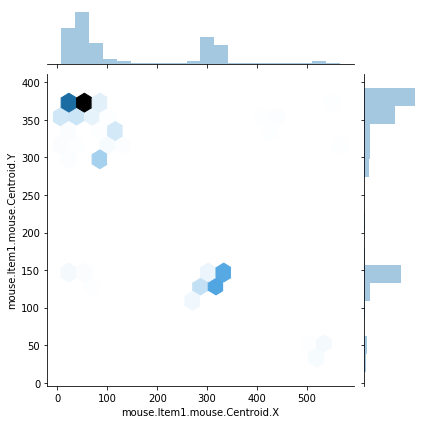

In [25]:
### mouse distance X 
mouseXdist = fid["mouse.Item1.mouse.Centroid.X"].diff()
### mouse distance Y 
mouseYdist = fid["mouse.Item1.mouse.Centroid.Y"].diff()

sns.jointplot(x="mouse.Item1.mouse.Centroid.X", 
              y="mouse.Item1.mouse.Centroid.Y", 
              data=fid,kind="hex",dropna=True,
              #xlim=[0,600],ylim=[0,500]
              )

In [5]:
# total distance using pytagoras, and excluding the times when the mouse was on the wheel
mouseTotalDist = np.sqrt(mouseXdist[fid["onlymouse"]]**2+mouseYdist[fid["onlymouse"]]**2) 

#print ("mouse moving distance: "+str(mouseTotalDist.sum()) + "in pixels")



mouse moving distance: 6199.220329555352in pixels


#### Moving time

Get the total moving time, wheel plus non-wheel


In [6]:
totalTime = fid["frameinterval"]
movingTime = totalTime[fid["onlymouse"]].sum() + totalTime[fid["wheelmoving"]].sum()

print("recording time: " + str(totalTime.sum())+ " seconds")
print("total moving time: " + str(movingTime) + " seconds")
print("wheel moving time: "+ str(totalTime[fid["wheelmoving"]].sum())+ " seconds")
print("mouse moving time: " + str(totalTime[fid["onlymouse"]].sum())+ " seconds")

recording time: 238.91964159999043 seconds
total moving time: 44.49887999991188 seconds
wheel moving time: 38.842483199900016 seconds
mouse moving time: 5.656396800011862 seconds


**calculate distance travelled while on the wheel**

The wheel has a black marker that is used to track its movement. the tracker is set close to the center of the wheel and the readings we have to work with are X and Y positions of this tracker in relation to the bottom left corner of the WheelROI (the next cell plots the raw data for better visualisation)

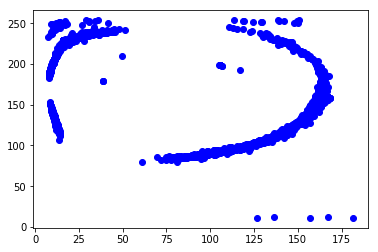

In [7]:
plt.plot(fid["wheel.Item2.wheel.Centroid.X"],fid["wheel.Item2.wheel.Centroid.Y"],'bo')

the above graph shows all detected X against Y positions of the wheel marker (this is a bit noisy at the moment, but can/should be cleaned up using bonsai). Gap on the top can happen because of a glare from the IR light from the camera leds.

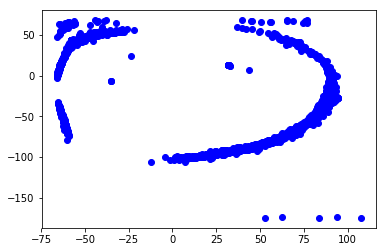

In [8]:
# get the x and y average positions are remove them from each dimension, so to "center" the wheel
wheelXavg = fid["wheel.Item2.wheel.Centroid.X"].mean()
wheelYavg = fid["wheel.Item2.wheel.Centroid.Y"].mean()


fid = fid.join(pd.Series(data = (fid["wheel.Item2.wheel.Centroid.X"]-wheelXavg),name="wheelXcentered"))
fid = fid.join(pd.Series(data = (fid["wheel.Item2.wheel.Centroid.Y"]-wheelYavg),name="wheelYcentered"))


plt.plot(fid["wheel.Item2.wheel.Centroid.X"]-wheelXavg,fid["wheel.Item2.wheel.Centroid.Y"]-wheelYavg,"bo")


With X' and Y' centered values, we can get distance travelled :  

1.calculate the tangent(alpha) value for each frame tan(alpha) = Y'/X'.  
2.calculate the arctan(alpha) which gives alpha in radians 
3.multiply radians by the radius (either the marker distance from the centre of the wheel, or the wheel radius -  which could be more accurate in terms of distance)  
4.get the difference between each frame  
5.sum the module of the differences  




In [9]:
#wheelradius: either the distance from marker to wheel center or actual wheel radius.
# here just set to 1 for demonstration purposes
wheelRadius = 1
#1
tanA = fid["wheelYcentered"]/fid["wheelXcentered"]
#2
arcTanA = np.arctan(tanA)
#3
wheelMov = arcTanA*wheelRadius
#4 
np.diff(wheelMov)
#5
wheelDist = np.sum(np.abs(wheelMov))


In [10]:
wheelDist

2948.919809792797

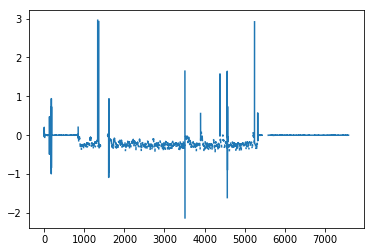

In [11]:
wheelRadius = 1
plt.plot(np.diff(np.arctan(tanA)))*wheelRadius

In [13]:
np.sum(np.abs(np.diff(np.arctan(tanA.dropna()))*wheelRadius))

972.0031091350038